In [1]:
import numpy as np
#import matplotlib as plt
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob, os
import random
import tensorflow as tf
from tensorflow import keras
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
from datetime import date
import xarray as xr
import netCDF4 as nc
#from u_interpolate_small import regrid_irregular_quick
#from ndays import numOfDays
import glob
import calendar
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix


2024-07-17 11:53:56.343359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
val_target_FILENAME = "val_target.npy"
val_input_FILENAME = "val_input.npy"

In [3]:
# read in data
val_input_dataset=np.load(val_input_FILENAME)
val_target_dataset=np.load(val_target_FILENAME)
print(val_input_dataset.shape)


(1441920, 124)


In [4]:
# training input
# temp
temp_surface = val_input_dataset[:,59]
temp_mid = val_input_dataset[:,29]
temp_top = val_input_dataset[:,0]

# specific humidity
sp_humidity_surface = val_input_dataset[:,60+29]
sp_humidity_mid = val_input_dataset[:,60+29]
sp_humidity_top = val_input_dataset[:,60]

# surface pressure
surface_pressure = val_input_dataset[:,-4]

# Insolation
insolation = val_input_dataset[:,-3]

# Surface latent heat flux
surface_latent_heat = val_input_dataset[:,-2]

# Surface sensible heat flux
surface_sensible_heat = val_input_dataset[:,-1]



In [5]:
# training target
rain_rate = val_target_dataset[:,-5]


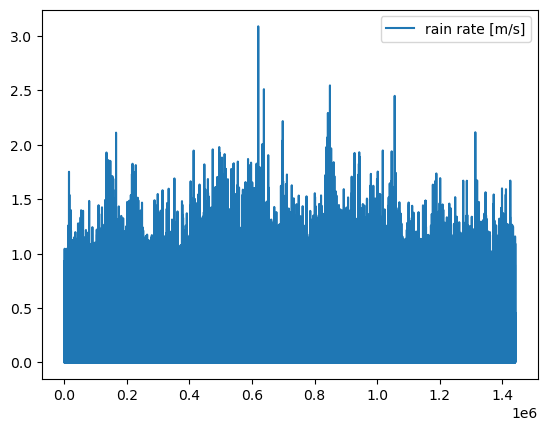

In [6]:
# # plot rain
plt.figure()
plt.plot(rain_rate,label='rain rate [m/s]')
#plt.plot(temp_top,linestyle='',marker='o', markersize=2,label='temp_top')
plt.legend()




In [10]:
# building model
#num_of_epochs= 10
num_of_samples = temp_surface.shape[0] 
num_of_inputs = 10

X_train= np.zeros((num_of_samples,num_of_inputs, 1))
X_train[:,0,0]=temp_surface
X_train[:,1,0]=temp_mid
X_train[:,2,0]=temp_top
X_train[:,3,0]=sp_humidity_surface
X_train[:,4,0]=sp_humidity_mid
X_train[:,5,0]=sp_humidity_top
X_train[:,6,0]=surface_pressure
X_train[:,7,0]=insolation
X_train[:,8,0]=surface_latent_heat
X_train[:,9,0]=surface_sensible_heat

y_train=rain_rate

index= np.arange(0,y_train.shape[0],1)


In [11]:
print(X_train.shape)
print(y_train.shape)
print(index.shape)

(1441920, 10, 1)
(1441920,)
(1441920,)


In [12]:
x_tr, x_test, y_tr, y_test, index_tr, index_test = train_test_split(X_train, y_train, index, test_size=0.4, random_state=42)

In [13]:
del X_train
x_tr.shape

(865152, 10, 1)

In [11]:
num_of_epochs = 10

In [12]:
from tensorflow import keras
#import tensorflow.keras.model
#from tensorflow.keras.layers import Conv1D, Flatten, Dense
#from tensorflow.keras.layers import Sequential

model = keras.models.Sequential()
model.add(keras.layers.Conv1D(32,kernel_size=2,activation='relu',input_shape=(num_of_inputs,1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))
model.compile(optimizer='adam',loss='mean_squared_error',metrics=[keras.metrics.Accuracy()])

 

/home/jawahm/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997 (11.71 KB)

 Trainable params: 2,997 (11.71 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(x_tr,y_tr,epochs=num_of_epochs,batch_size=1)


Epoch 1/2
504672/504672 ━━━━━━━━━━━━━━━━━━━━ 301s 595us/step - accuracy: 0.0000e+00 - loss: 0.0072
Epoch 2/2
504672/504672 ━━━━━━━━━━━━━━━━━━━━ 300s 595us/step - accuracy: 0.0000e+00 - loss: 0.0062


In [18]:
print(x_test.shape)
print(y_test.shape)
#x_tr.shape


(937248, 10, 1)

In [14]:
with open('saved_models/CNN_10_input_1_output.pkl', 'wb') as file: 
          pickle.dump(model, file) 

#with open('saved_models/CNN_10_input_1_output.pkl', 'rb') as file: 
 #         model = pickle.load(file) 
 

In [16]:
num_test_samples=1000
frames= np.zeros((num_test_samples,num_of_inputs, 1))
predicted_y= np.zeros((num_test_samples))

for i in range(0,num_test_samples,1):
    frames = x_test[i,:,:] # 
    #original_frame[i,:,:] = y_test[i,:,:] # 
    
    # Extract the model's prediction and post-process it.
#    predicted_frames[i,:,:] = np.squeeze(model.predict(x_test[i,:,:] )))
    predicted_y[i] = model.predict(np.expand_dims(frames, axis=0))
    
   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_369242/85263520.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_y[i] = model.predict(np.expand_dims(frames, axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [20]:
metrics.mean_squared_error(y_test[0:num_test_samples], predicted_y)

0.005374275707582402